In [444]:
import pandas as pd
from pandas import DataFrame
from pandas.tseries.offsets import DateOffset
import numpy as np
from pandas.plotting import autocorrelation_plot
import pandas.util.testing as tm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from numpy import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

In [445]:
# Leitura do CSV e setando como Time
df = pd.read_csv('FT03_18_19.csv',delimiter=';', parse_dates=True)
df['Time'] = pd.to_datetime(df.Time)
df = df[df['Time'].notna()]
df = df.set_index('Time')
df = df.resample("D").last()

In [446]:
#Separar dados de treino e teste
dias = 30
train = df.iloc[:-dias,0:1].copy()
test = df.iloc[-dias:,0:1].copy()

history = [train.iloc[i,0] for i in range(len(train))]
predictions = []

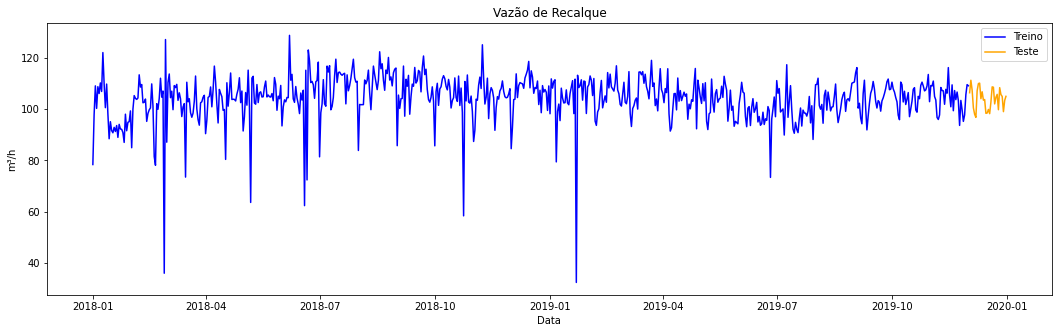

In [447]:
# Visualização das amostras de treino e teste
plt.figure(figsize=(18,5))
plt.title('Vazão de Recalque')
plt.plot(train['Vazao03'], color='b')
plt.plot(test['Vazao03'], color='orange')
plt.legend(['Treino','Teste'])
plt.xlabel('Data')
plt.ylabel('m³/h')
plt.show()

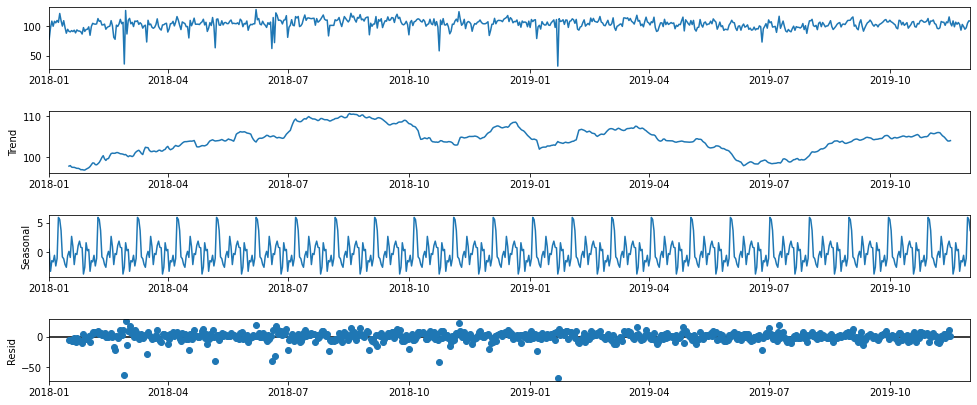

In [448]:
#Verificando Residuais, Sazonalidade e Tendencias
result = seasonal_decompose(train, freq=30)
fig = result.plot()
fig.set_size_inches(15,6)

In [449]:
#Verificando atraves de Dickey Fuller a estacionariedade
X = df.values
result = adfuller(X)
print(result)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

(-7.376970906243426, 8.671089428931667e-11, 6, 723, {'1%': -3.4394269973845657, '5%': -2.8655458544300387, '10%': -2.568903174551249}, 5007.209057665952)
ADF Statistic: -7.376971
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569


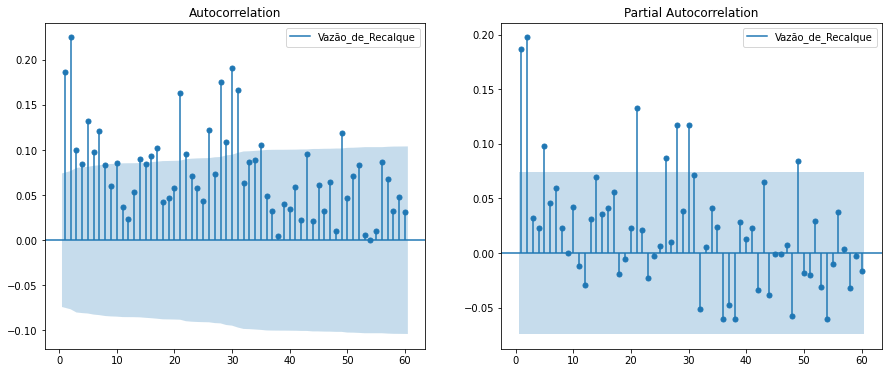

In [450]:
# Análise de auto correlação dos lags anteriores
fig, ax = plt.subplots(1,2,figsize=(15,6))
plot_acf(train['Vazao03'], lags=60, zero=False, ax=ax[0]);
plot_pacf(train['Vazao03'], lags=60, zero=False, ax=ax[1]);
ax[0].legend(["Vazão_de_Recalque"], loc="upper right")
ax[1].legend(["Vazão_de_Recalque"], loc="upper right")
plt.show()

In [451]:
#Rodar o ARIMA para os dados de treino, fazer forecast para o tamanho dos dados test
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test.iloc[t,0]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
test['Predict'] = predictions

predicted=109.303024, expected=106.310000
predicted=107.777059, expected=111.160000
predicted=108.673778, expected=107.350000
predicted=109.396542, expected=100.430000
predicted=104.089650, expected=97.920000
predicted=99.261987, expected=96.720000
predicted=97.373443, expected=107.030000
predicted=101.679347, expected=109.870000
predicted=108.439347, expected=110.040000
predicted=110.005016, expected=103.980000
predicted=107.187523, expected=106.680000
predicted=105.315649, expected=103.410000
predicted=105.158296, expected=103.670000
predicted=103.574059, expected=98.290000
predicted=101.129696, expected=98.400000
predicted=98.371101, expected=99.810000
predicted=99.104973, expected=98.160000
predicted=99.049926, expected=102.680000
predicted=100.355999, expected=108.590000
predicted=105.554793, expected=108.440000
predicted=108.567902, expected=101.960000
predicted=105.377278, expected=104.530000
predicted=103.230302, expected=105.680000
predicted=105.123655, expected=99.700000
pred

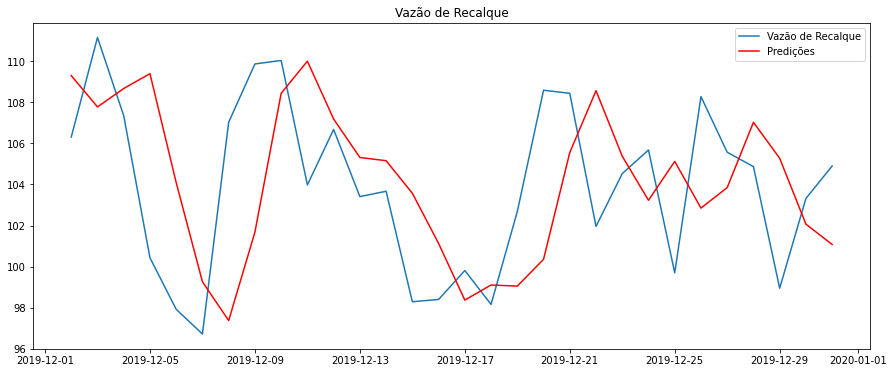

In [452]:
# Plotar a previsão e comparar com os testes
plt.figure(figsize=(15,6))
plt.plot(test['Vazao03'])
plt.plot(test['Predict'], color='red')
plt.title('Vazão de Recalque')
plt.legend(['Vazão de Recalque', 'Predições'], loc="upper right")
plt.show()

In [453]:
# -----------------------------Função para analisar erros--------------------------------
def check_erro(orig, prev, nome_col='', nome_indice=''):
    
    mse = mean_squared_error(orig, prev)
    rmse = sqrt(mean_squared_error(orig, prev))
    mae = mean_absolute_error(orig, prev)
    mape = mean_absolute_percentage_error(orig, prev)
    
    grupo_erro = [mse, rmse, mae, mape]
    serie = pd.DataFrame(grupo_erro, index=['MSE','RMSE','MAE', 'MAPE'], columns=[nome_col])
    serie.index.name = nome_indice
    
    return serie
    
def plotar_erro(dados, figsize=(15,6)):
    
    # Criando a coluna do erro
    dados['Erro'] = dados.iloc[:,0] - dados.iloc[:,1]
    
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))
    
    #Plotando os valores reais e previstos
    ax1.plot(dados.iloc[:,0:2])
    ax1.legend(['Real','Prev'])
    ax1.set_title('Valores Reais vs Previstos')
    
    # Erro vs Valores previstos
    ax2.scatter(dados.iloc[:,1], dados.iloc[:,2])
    ax2.set_xlabel('Valores Previstos')
    ax2.set_ylabel('Resíduo')
    ax2.set_title('Resíduo vs Valores Previstos')
    
    ## QQ Plot do erro
    ax3.set_title('Gráfico QQ')
    sm.graphics.qqplot(dados.iloc[:,2], line='r', ax=ax3)
    
    # Gráfico de autocorrelação do Erro
    plot_acf(dados.iloc[:,2], lags=29, zero=False, ax=ax4)
    plt.tight_layout()
    plt.show()

MODELO ARIMA PARA O TREINO COMPARADO NA BASE DE TESTE


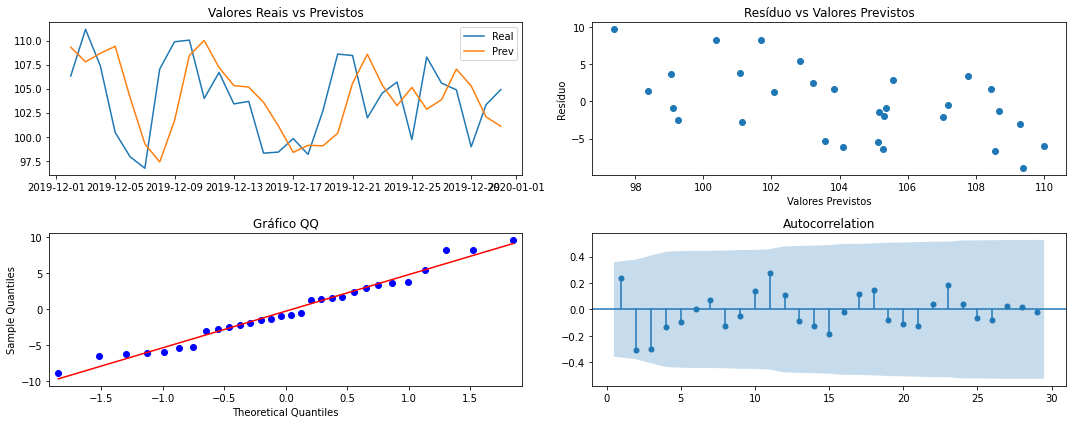

,Erros
Base Treino,
MSE,21.770608
RMSE,4.665898
MAE,3.864544
MAPE,0.037254


In [454]:
erro_teste = check_erro(test['Vazao03'], test['Predict'], nome_col='Erros',nome_indice='Base Treino')
print('MODELO ARIMA PARA O TREINO COMPARADO NA BASE DE TESTE')

plotar_erro(test)
erro_teste